### Vegetation loss (extent) case study
Hinchinbrook Island, QLD  
Mangrove extent loss due to cyclone Yasi in 2011  
Impact = Vegetation loss (extent)  
Pressure = Excess rainfall, strong winds, Storm surge  


#### Data
Impacts observed through DEA Land Cover  
Level 3 change assessed  
Level 4 change assessed  
Perhaps changes are linked to potential impacts?  
Where impact is identified, goes to config file of potential pressures and this links to virtual products  


In [1]:
import sys
import numpy as np
import xarray as xr
import geopandas as gpd
import datacube

import matplotlib.pyplot as plt

from datacube.utils.geometry import Geometry, CRS
from dea_tools.plotting import rgb, display_map

dc = datacube.Datacube()

# impacts and pressures functions
sys.path.append('/home/jovyan/code/living_coasts/functions')
from impacts import vegetation_loss, vegetation_damage

# for virtual products
import yaml
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/vegetation_loss_config.yaml')
sys.path.append('/home/jovyan/code/living_coasts/virtual_products')

### User inputs

In [2]:
# add in vector data for area of interest
AOI = '../data/vector_data/AOIs/Hinchinbrook_Island.geojson'
AOI = gpd.read_file(AOI)

# annual years of change for identifying impact
pre_impact_year = '2010'
post_impact_year = '2011'

In [3]:
display_map(x=(AOI.total_bounds[0], AOI.total_bounds[2]), y=(AOI.total_bounds[1], AOI.total_bounds[3]))

In [4]:
# datacube query
resolution = (-25,25) # collection 2 = 25m, collection 3 = 30m
query_pre_impact = {
    'time': (pre_impact_year, pre_impact_year),
    'resolution':resolution}

query_post_impact = {
    'time': (post_impact_year, post_impact_year),
    'resolution':resolution}

# Loop through polygons in geodataframe and extract satellite data
for index, row in AOI.iterrows(): 
    # Extract the feature's geometry as a datacube geometry object (this needs to be updated eventually for Shapely 2.0)
    geom = Geometry(geom=row.geometry, crs=AOI.crs)
    # Update the query to include our geopolygon
    query_pre_impact.update({'geopolygon': geom})
    query_post_impact.update({'geopolygon': geom})

## Impact = Vegetation loss (extent)
Observed through DEA Land Cover

In [5]:
vegetation_loss = vegetation_loss(query_pre_impact, query_post_impact)

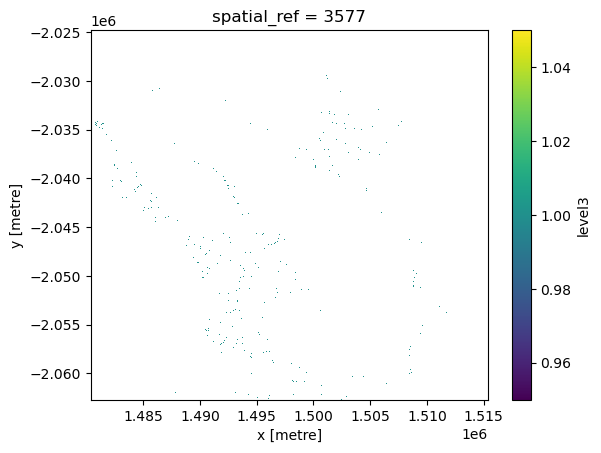

In [6]:
vegetation_loss.plot()

## Impact = Vegetation Damage
Observed through DEA Land Cover

In [7]:
vegetation_damage = vegetation_damage(query_pre_impact, query_post_impact)

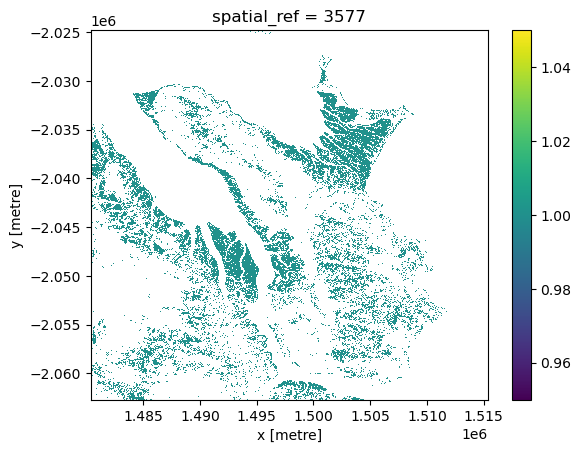

In [8]:
vegetation_damage.plot()

## Potential Pressures

### Bushfire
- idea here is to load for each time series the NBR
- then calc dNBR and threshold with burnt area like here (https://knowledge.dea.ga.gov.au/notebooks/Real_world_examples/Burnt_area_mapping/)
- then mask based on pixels from impact data
- print out % pixels affected by potential pressure

In [12]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = 'bushfire'
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class))

In [13]:
# see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

{'make_mask': datacube.virtual.transformations.MakeMask,
 'apply_mask': datacube.virtual.transformations.ApplyMask,
 'to_float': datacube.virtual.transformations.ToFloat,
 'rename': datacube.virtual.transformations.Rename,
 'select': datacube.virtual.transformations.Select,
 'expressions': datacube.virtual.transformations.Expressions,
 'bushfire': bushfire.bushfire}

In [14]:
# load bushfire
product = catalog['bushfire']
bushfire_pre_impact = product.load(dc, **query_pre_impact)

# load bushfire
product = catalog['bushfire']
bushfire_post_impact = product.load(dc, **query_post_impact)

In [15]:
# Calculate dNBR by dropping the time dimension
pre_nbr = bushfire_pre_impact['NBR'].squeeze()  
post_nbr = bushfire_post_impact['NBR'].squeeze()  
dNBR = pre_nbr - post_nbr

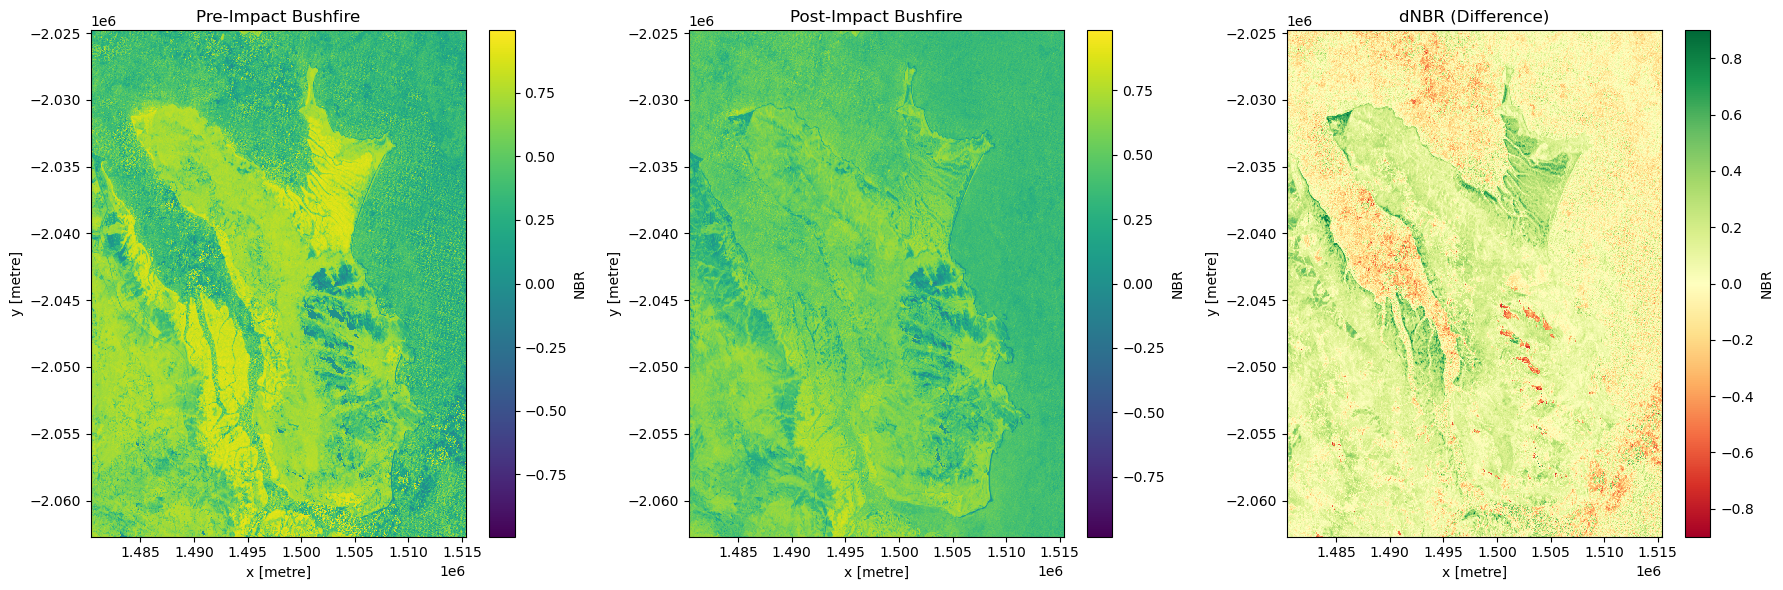

In [16]:
# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pre-impact bushfire
pre_nbr.plot(ax=axs[0], cmap='viridis')
axs[0].set_title('Pre-Impact Bushfire')

# Post-impact bushfire
post_nbr.plot(ax=axs[1], cmap='viridis')
axs[1].set_title('Post-Impact Bushfire')

# dNBR
dNBR.plot(ax=axs[2], cmap='RdYlGn')
axs[2].set_title('dNBR (Difference)')

plt.tight_layout()
plt.show()

In [17]:
# Set threshold
threshold = 0.3

# Apply threshold
burnt = dNBR > threshold

# Mask post-fire true colour image
masked_dNBR = dNBR.where(burnt==1)

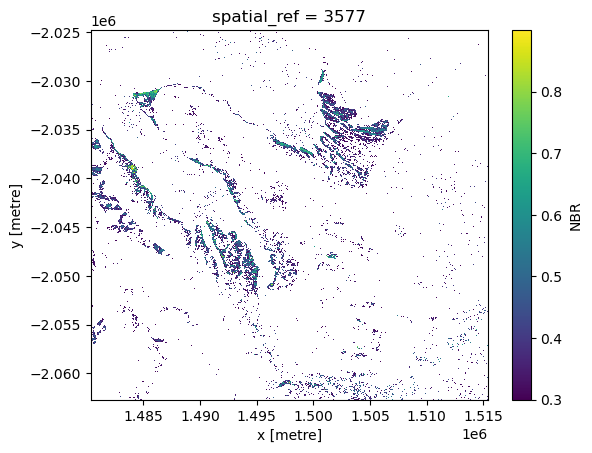

In [18]:
masked_dNBR.plot()

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


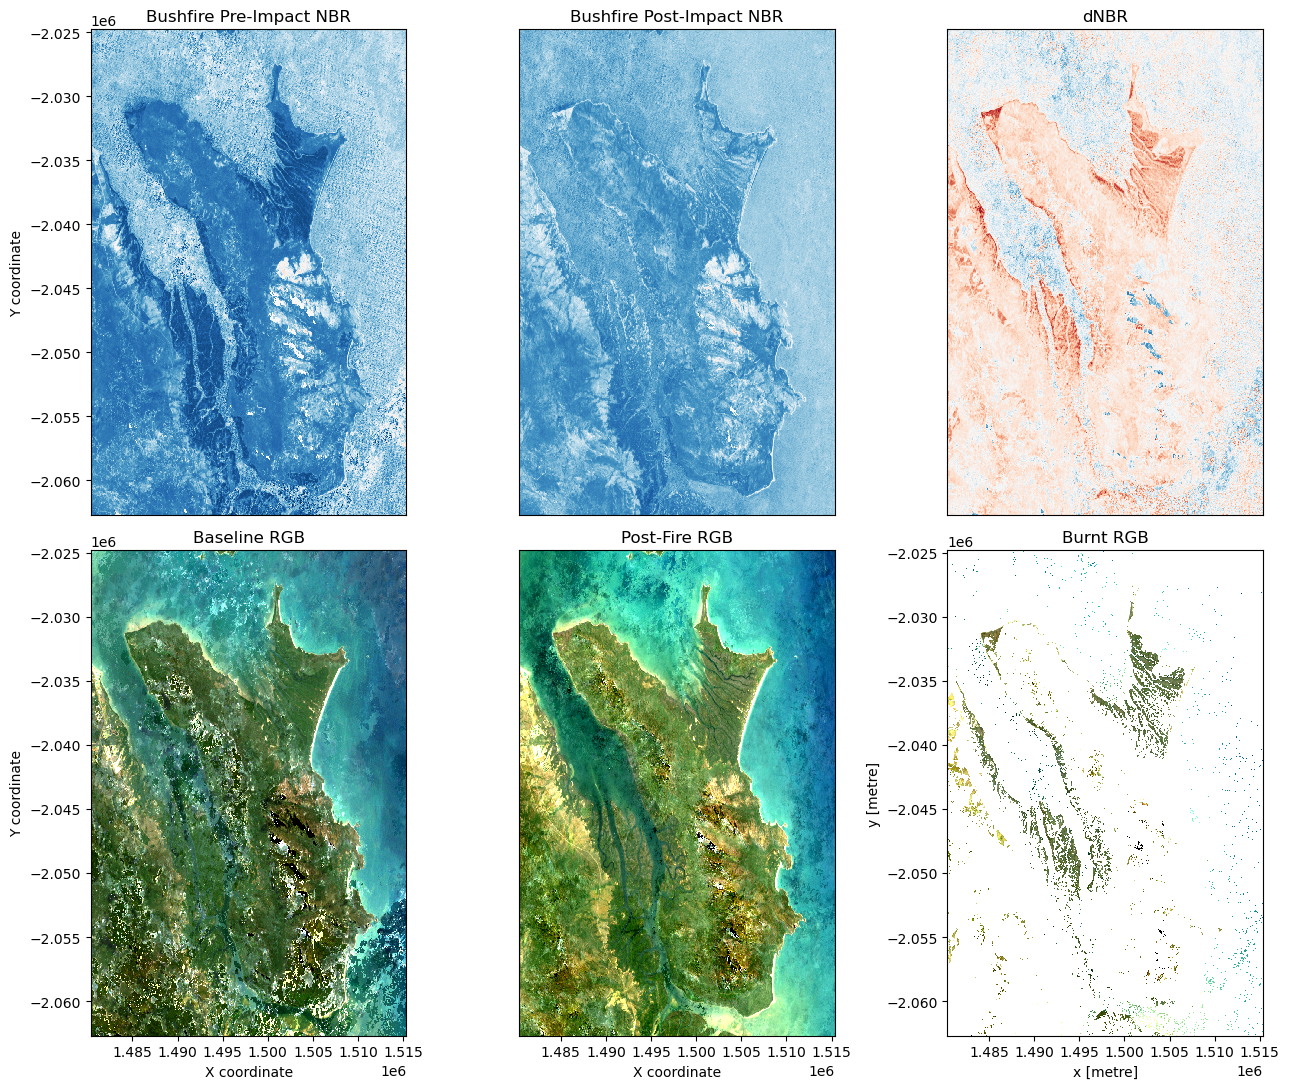

In [20]:
import matplotlib.pyplot as plt
from dea_tools.plotting import rgb

# Set up subplots
fig, axarr = plt.subplots(2, 3, figsize=(13, 11))

# Plot NBR data
bushfire_pre_impact['NBR'].plot(cmap='RdBu', vmin=-1, vmax=1,
                                add_colorbar=False, ax=axarr[0, 0])
axarr[0, 0].set_title('Bushfire Pre-Impact NBR')
axarr[0, 0].set_ylabel('Y coordinate')
axarr[0, 0].xaxis.set_visible(False)

bushfire_post_impact['NBR'].plot(cmap='RdBu', vmin=-1, vmax=1,
                                 add_colorbar=False, ax=axarr[0, 1])
axarr[0, 1].set_title('Bushfire Post-Impact NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].xaxis.set_visible(False)

dNBR.plot(cmap='RdBu_r', vmin=-1, vmax=1,
          add_colorbar=False, ax=axarr[0, 2])
axarr[0, 2].set_title('dNBR')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

# Plot RGB images
rgb(bushfire_pre_impact, bands=['red', 'green', 'blue'], ax=axarr[1, 0])
axarr[1, 0].set_title('Baseline RGB')
axarr[1, 0].set_xlabel('X coordinate')
axarr[1, 0].set_ylabel('Y coordinate')

rgb(bushfire_post_impact, bands=['red', 'green', 'blue'], ax=axarr[1, 1])
axarr[1, 1].set_title('Post-Fire RGB')
axarr[1, 1].set_xlabel('X coordinate')
axarr[1, 1].yaxis.set_visible(False)

# Check if `burnt` is defined and valid
if 'burnt' in locals():
    rgb(bushfire_post_impact.where(burnt == 1), bands=['red', 'green', 'blue'], ax=axarr[1, 2])
    axarr[1, 2].set_title('Burnt RGB')
else:
    axarr[1, 2].set_title('Burnt RGB (Mask not defined)')
    axarr[1, 2].set_xlabel('X coordinate')
    axarr[1, 2].yaxis.set_visible(False)

plt.tight_layout()
plt.show()


Resampled vegetation damage mask spatial resolution: 30.00 (x), -30.00 (y)
% pixels affected by potential pressure: 5.74%


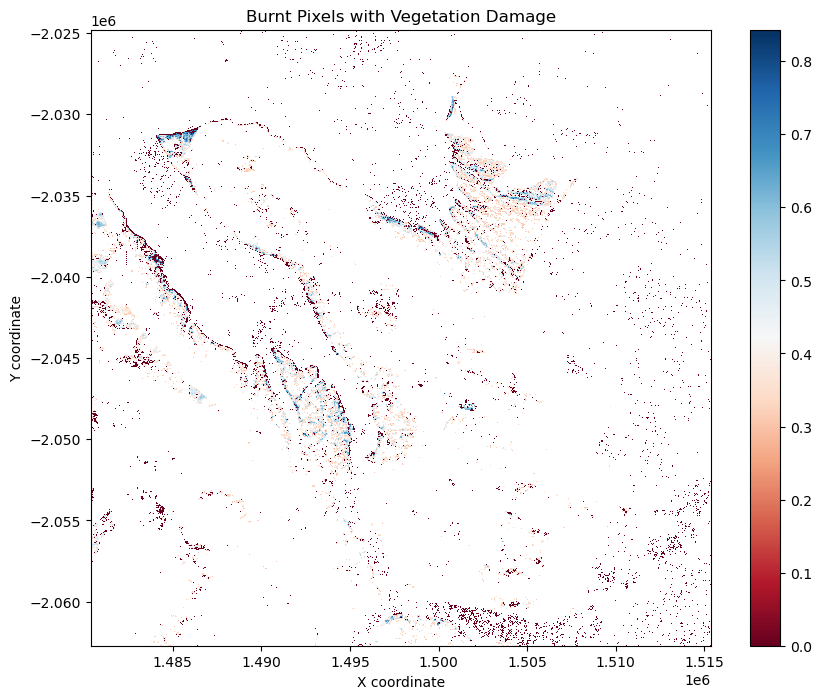

In [37]:
# Function to resample data
def resample_to_match(source, target):
    # Convert boolean to numeric
    source_numeric = source.astype(float)  # Convert boolean to float (0s and 1s)
    
    # Reindex source data to match target's coordinate grid
    resampled = source_numeric.reindex_like(target, method='nearest')
    return resampled

# Resample the vegetation damage mask to match dNBR resolution
vegetation_damage_resampled = resample_to_match(vegetation_damage_mask, masked_dNBR)

# Check the new spatial resolution
resampled_x_res = vegetation_damage_resampled.coords['x'].diff(dim='x').mean().item()
resampled_y_res = vegetation_damage_resampled.coords['y'].diff(dim='y').mean().item()
print(f"Resampled vegetation damage mask spatial resolution: {resampled_x_res:.2f} (x), {resampled_y_res:.2f} (y)")

# Multiply the resampled vegetation damage mask with dNBR
correlated_damage_burn = vegetation_damage_resampled * masked_dNBR

# Calculate the percentage of pixels with both burnt and vegetation damage
total_pixels = correlated_damage_burn.size
non_nan_pixels = correlated_damage_burn.notnull().sum().item()
percentage_burn_vegetation_damage = (non_nan_pixels / total_pixels) * 100

# Print the percentage of pixels with both burnt and vegetation damage
print(f"% pixels affected by potential pressure: {percentage_burn_vegetation_damage:.2f}%")

# Plot the result
plt.figure(figsize=(10, 8))
correlated_damage_burn.plot(cmap='RdBu', add_colorbar=True)
plt.title('Burnt Pixels with Vegetation Damage')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()
